In [186]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [187]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [188]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens5 == 1]
    counts = relapsed['Illicit_Days5'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [189]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

def run_models(X, y, label):
    gbsa = GradientBoostingSurvivalAnalysis()
    scores = cross_validate(gbsa, X, y, cv=5)
    gbsa_score = scores['test_score'].mean()
    print('RF Boosted score:', gbsa_score)
    
    gbsa = GradientBoostingSurvivalAnalysis()
    gbsa.fit(X, y)
    
    rsf = RandomSurvivalForest()
    scores = cross_validate(rsf, X, y, cv=5)
    rsf_score = scores['test_score'].mean()
    print('RF score:', rsf_score)
    
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    scores = cross_validate(rcr, X, y, cv=5)
    rcr_score = scores['test_score'].mean()
    print('Lasso score:', rcr_score)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(X, y)
    
    # concordance index
    scores = {'Model': ['Random Forest Boosted','Random Forest','Lasso','Dataset Size'], 
              label: [gbsa_score,rsf_score,rcr_score,X.shape[0]]}
    
    concordance = pd.DataFrame(data=scores)
    
    # return scores and models
    return concordance, gbsa, rsf, rcr

In [190]:
def get_survival_graph(rsf, rcr, X, Y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)
    pred_surv_rcr = rcr.predict_survival_function(X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(Y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [191]:
def get_feature_importance(features, gbsa, rcr, label):
    # feature importances from Boosted Random Forest
    feature_importance_rf = pd.DataFrame({'Feature':features, label:gbsa.feature_importances_,})
    feature_importance_rf.sort_values(by=[label], ascending=False, inplace=True)
    feature_importance_rf = feature_importance_rf.nlargest(10,[label]) # keep top 10 features
    feature_importance_rf = feature_importance_rf[feature_importance_rf[label] != 0]

    # feature importances from Lasso
    feature_importance_lasso = pd.DataFrame({'Feature':features, #temp,
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    feature_importance_lasso[label + '_abs'] = np.absolute(feature_importance_lasso[label])
    feature_importance_lasso = feature_importance_lasso.nlargest(10,[label + '_abs']) # keep top 10 features
    feature_importance_lasso = feature_importance_lasso[feature_importance_lasso[label] != 0]
    
    return feature_importance_rf, feature_importance_lasso

Survival Analysis by Severity

In [192]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset_stratified_test.csv')    
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,gran,pop_deng,%_dropoutg,%_unemployedg,%_public_assistanceg,%_povertyg
0,1601,2927,2931,22259,WA,Tacoma,2502 Tacoma Avenue South,2012,67,0,0,0,0,1,2,0,2,1,1,2,2,2,1,2,2,2,0,0,1,0,0,0,0,8,"2502 Tacoma Avenue South, Tacoma, WA",47.238202,-122.441249,Washington,53053.0,5.305306e+14,0,1.0,0.0,0.0,0.0,0.0,1.0
1,2032,3696,3700,22260,WA,Tacoma,2502 Tacoma Avenue South,2012,87,0,0,0,0,0,2,0,1,0,1,1,0,2,1,1,0,2,1,0,0,0,0,0,1,1,"2502 Tacoma Avenue South, Tacoma, WA",47.238202,-122.441249,Washington,53053.0,5.305306e+14,0,1.0,0.0,0.0,0.0,0.0,1.0
2,2037,3701,3705,22357,WA,Tacoma,2502 Tacoma Avenue South,2012,156,0,0,0,0,1,1,0,1,1,2,1,0,2,1,2,1,0,0,0,0,0,1,0,1,4,"2502 Tacoma Avenue South, Tacoma, WA",47.238202,-122.441249,Washington,53053.0,5.305306e+14,0,1.0,0.0,0.0,0.0,0.0,1.0
3,2763,4815,4819,22204,WA,Tacoma,2502 Tacoma Avenue South,2012,84,0,0,0,0,0,2,0,1,1,2,2,2,1,1,1,0,2,0,0,1,0,0,0,1,0,"2502 Tacoma Avenue South, Tacoma, WA",47.238202,-122.441249,Washington,53053.0,5.305306e+14,0,1.0,0.0,0.0,0.0,0.0,1.0
4,2769,4821,4825,22248,WA,Tacoma,2502 Tacoma Avenue South,2012,66,0,0,0,0,0,2,0,0,0,0,0,1,2,1,2,0,0,0,0,1,0,0,0,1,0,"2502 Tacoma Avenue South, Tacoma, WA",47.238202,-122.441249,Washington,53053.0,5.305306e+14,0,1.0,0.0,0.0,0.0,0.0,1.0


In [193]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','srprobg_cd','county_FIPS','block_FIPS']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops columns without census or crime data

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10009, 31)

In [194]:
df.shape

(10009, 31)

In [195]:
df.head()

,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,murder_numg,pop_deng,%_dropoutg,%_unemployedg,%_public_assistanceg,%_povertyg
0,161,0,0,0,0,1,0,0,0,0,0,0,1,2,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
1,192,0,0,1,0,1,2,0,0,1,1,0,2,1,1,0,2,0,1,0,0,0,0,1,5,0,0,0,0,0,0
2,153,0,1,0,0,1,1,0,2,1,2,1,0,2,2,0,1,1,0,0,0,0,0,1,2,0,0,0,0,0,0
3,41,1,0,1,0,1,0,0,1,1,0,1,2,2,2,2,2,0,0,1,0,0,0,1,6,0,0,0,0,0,0
4,95,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0


Full Population Survival Analysis

In [196]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days5'
censoring_var = 'Illicit_Cens5'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10009, 29) (10009,)


In [197]:
%%time
full_concordance, gbsa, rsf, rcr = run_models(X, y, 'ALL')

RF Boosted score: 0.6752049918888716
RF score: 0.6685536168127698
Lasso score: 0.6763518513752549
CPU times: user 10min 23s, sys: 7.13 s, total: 10min 30s
Wall time: 11min 3s


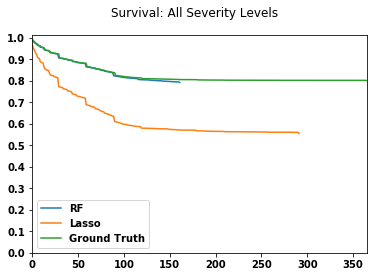

In [198]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: All Severity Levels','graphs/survival_all.png')

Subclinical Severity Survival Analysis

In [199]:
X = df[df.SUDSy_0 < 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3246, 28) (3246,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [200]:
%%time
subclinical_concordance, gbsa, rsf, rcr = run_models(X, y, 'SUB')

RF Boosted score: 0.652391871656375
RF score: 0.6494673446054967
Lasso score: 0.6675887692963067
CPU times: user 1min 4s, sys: 949 ms, total: 1min 5s
Wall time: 1min 7s


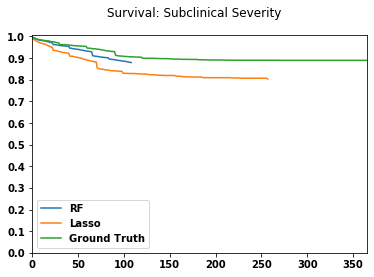

In [201]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Subclinical Severity', 'graphs/survival_subclinical.png')

In [202]:
subclinical_feature_importance_rf, subclinical_feature_importance_lasso = \
                                        get_feature_importance(X.columns, gbsa, rcr, 'SUB')

Mild/Moderate Severity Survival Analysis

In [203]:
X = df[df.SUDSy_0 >= 2]
X = X[X.SUDSy_0 <= 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2827, 28) (2827,)


In [204]:
%%time
mild_concordance, gbsa, rsf, rcr = run_models(X, y, 'MILD')

RF Boosted score: 0.5850369397446483
RF score: 0.5736474558394358
Lasso score: 0.5840622279015482
CPU times: user 52.2 s, sys: 694 ms, total: 52.9 s
Wall time: 53.7 s


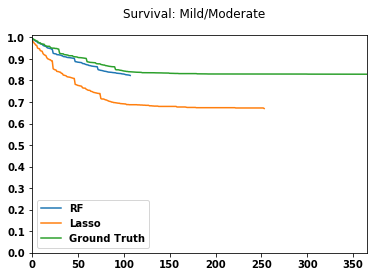

In [205]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Mild/Moderate', 'graphs/survival_mild.png')

In [206]:
mild_feature_importance_rf, mild_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'MILD')

Severe Severity Survival Analysis

In [207]:
X = df[df.SUDSy_0 > 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3936, 28) (3936,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [208]:
%%time
severe_concordance, gbsa, rsf, rcr = run_models(X, y, 'SEVERE')

RF Boosted score: 0.6158440432282928
RF score: 0.5999332102698272
Lasso score: 0.6127000875380142
CPU times: user 1min 48s, sys: 1.49 s, total: 1min 49s
Wall time: 1min 52s


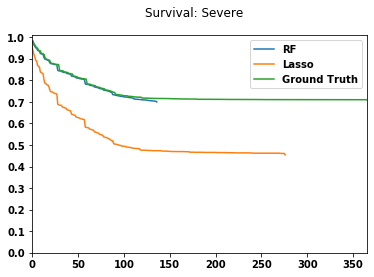

In [209]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Severe', 'graphs/survival_severe.png')

In [210]:
severe_feature_importance_rf, severe_feature_importance_lasso = get_feature_importance(X.columns, gbsa, rcr, 'SEVERE')

Overall Statistics

In [211]:
overall_concordance = pd.concat([subclinical_concordance, mild_concordance['MILD'], severe_concordance['SEVERE'],  
                                 full_concordance['ALL']], axis=1)
pd.DataFrame(data=overall_concordance).round(4)

,Model,SUB,MILD,SEVERE,ALL
0,Random Forest Boosted,0.6524,0.5850,0.6158,0.6752
1,Random Forest,0.6495,0.5736,0.5999,0.6686
2,Lasso,0.6676,0.5841,0.6127,0.6764
3,Dataset Size,3246.0000,2827.0000,3936.0000,10009.0000


In [212]:
overall_feature_importance_lasso = pd.merge(subclinical_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
0,cjsig_0_cd,0.165078,0.165078,0.000000,0.000000,0.000000,0.000000
1,r4ag_0_cd,0.103248,0.103248,0.095068,0.095068,0.091765,0.091765
2,gvsg_cd,0.097169,0.097169,0.022964,0.022964,0.000000,0.000000
3,B2a_0g,0.062789,0.062789,0.000000,0.000000,-0.010394,0.010394
4,dssg_0_cd,0.057087,0.057087,0.000000,0.000000,0.073060,0.073060
5,primsev_cd_2,-0.028912,0.028912,0.000000,0.000000,0.000000,0.000000
6,murder_numg,-0.022655,0.022655,0.000000,0.000000,0.000000,0.000000
7,prsatx_cd,0.020186,0.020186,0.078122,0.078122,0.012800,0.012800
8,cdsg_0_cd,0.019061,0.019061,0.000000,0.000000,0.053024,0.053024
,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs


In [213]:
hazards = overall_feature_importance_lasso[['SUB','MILD','SEVERE','Feature']]
hazards['exp(SUB)'] = np.exp(overall_feature_importance_lasso['SUB'])
hazards['exp(MILD)'] = np.exp(overall_feature_importance_lasso['MILD'])
hazards['exp(SEVERE)'] = np.exp(overall_feature_importance_lasso['SEVERE'])

hazards.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SUB,MILD,SEVERE,Feature,exp(SUB),exp(MILD),exp(SEVERE)
0,0.165078,0.000000,0.000000,cjsig_0_cd,1.179485,1.000000,1.000000
1,0.103248,0.095068,0.091765,r4ag_0_cd,1.108766,1.099734,1.096108
2,0.097169,0.022964,0.000000,gvsg_cd,1.102046,1.023230,1.000000
3,0.062789,0.000000,-0.010394,B2a_0g,1.064802,1.000000,0.989660
4,0.057087,0.000000,0.073060,dssg_0_cd,1.058748,1.000000,1.075795


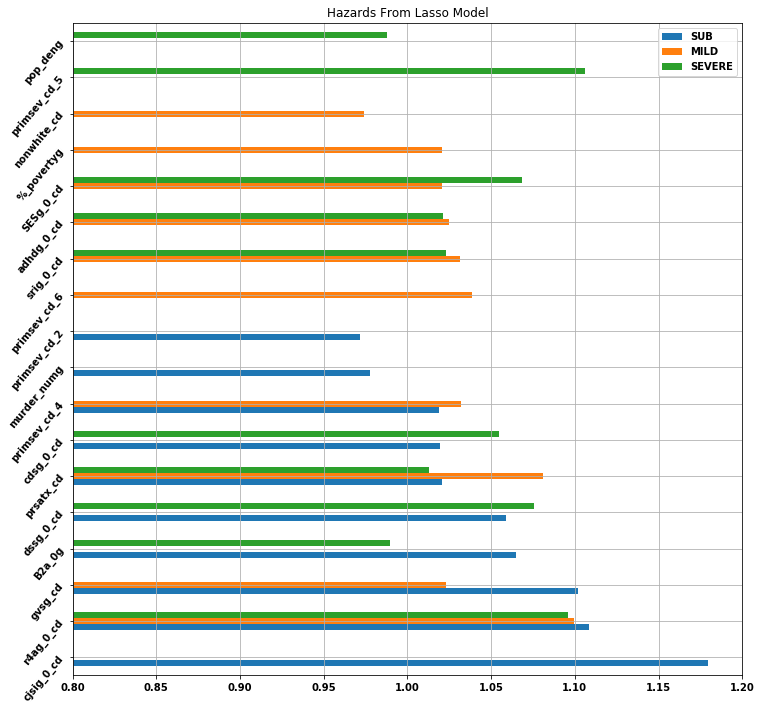

In [214]:
haz_df = pd.DataFrame({'SUB': hazards['exp(SUB)'].tolist(),
                   'MILD': hazards['exp(MILD)'].tolist(),
                   'SEVERE': hazards['exp(SEVERE)'].tolist()},
                  index=hazards['Feature'].tolist())
haz_df = haz_df.replace(1, 0)
haz_df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = haz_df.plot.barh(rot=50, figsize=(12, 12))
ax.set_xlim([0.8,1.2])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso.png', bbox_inches='tight')

In [215]:
overall_feature_importance_rf = pd.merge(subclinical_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,cjsig_0_cd,0.205732,0.000000,0.046133
1,B2a_0g,0.156530,0.000000,0.040820
2,gvsg_cd,0.084874,0.000000,0.000000
3,r4ag_0_cd,0.082748,0.110175,0.155443
,Feature,SUB,MILD,SEVERE
4,primsev_cd_4,0.081732,0.070654,0.000000
5,prsatx_cd,0.062300,0.100993,0.000000
6,SESg_0_cd,0.058948,0.000000,0.102372
7,murder_numg,0.055835,0.000000,0.000000
,Feature,SUB,MILD,SEVERE


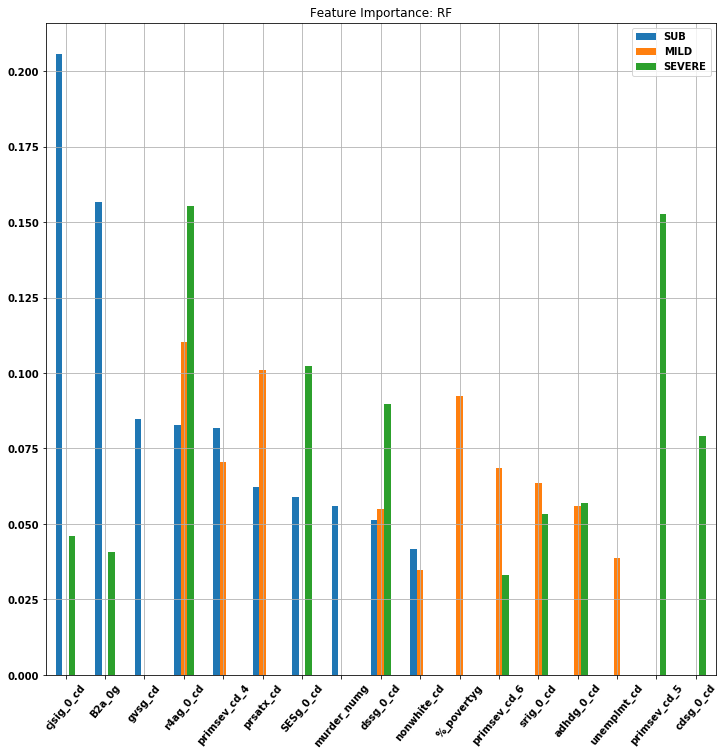

In [216]:
# feature importance for rf across all ages
df = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist(),
                   'MILD': overall_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = df.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_rf.png', bbox_inches='tight')

In [217]:
# features in top 10 of both models across all ages
feature_importance_intersection = np.intersect1d(overall_feature_importance_rf['Feature'], 
                                                 overall_feature_importance_lasso['Feature'])
print('Common Features:', *list(feature_importance_intersection), sep =', ')

Common Features:, %_povertyg, B2a_0g, SESg_0_cd, adhdg_0_cd, cdsg_0_cd, cjsig_0_cd, dssg_0_cd, gvsg_cd, murder_numg, nonwhite_cd, primsev_cd_4, primsev_cd_5, primsev_cd_6, prsatx_cd, r4ag_0_cd, srig_0_cd


In [218]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 15 minutes 5 seconds ---
